#### **Exercise 1**

Remove the outliers from the `sample_data_with_outliers.csv`!  Plot boxplots of the two features before and after outlier removal.  Try using different methods.  What works the best?

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

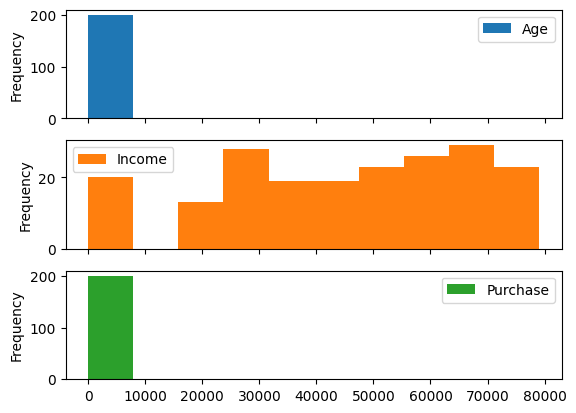

In [1]:
import pandas as pd
data = pd.read_csv("./data/sample_data_with_outliers.csv")
data.plot.hist(subplots=True)

<Axes: ylabel='Frequency'>

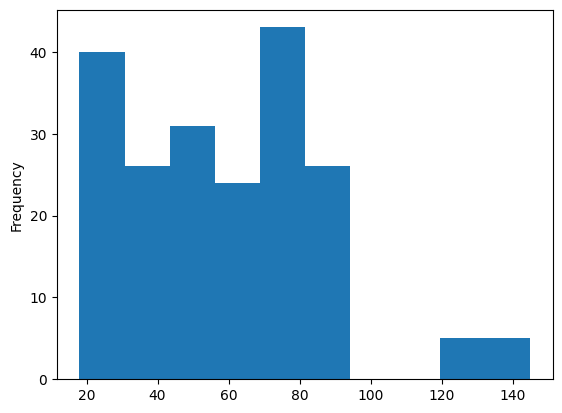

In [2]:
data['Age'].plot.hist()

Age            Axes(0.125,0.11;0.227941x0.77)
Income      Axes(0.398529,0.11;0.227941x0.77)
Purchase    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

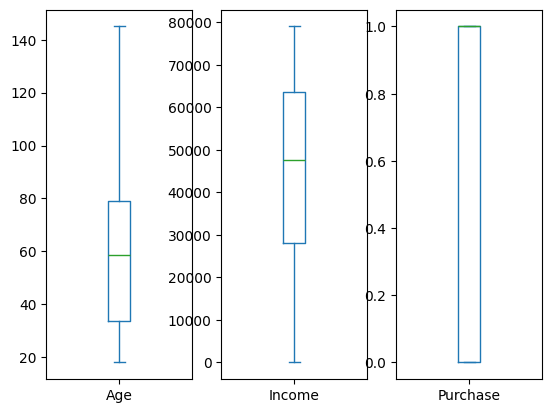

In [3]:
data.plot.box(subplots=True)

Age            Axes(0.125,0.11;0.227941x0.77)
Income      Axes(0.398529,0.11;0.227941x0.77)
Purchase    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

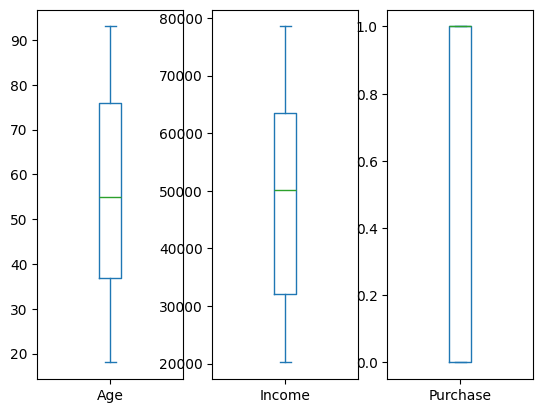

In [4]:
# If we're feeling bold, we can use IsolationForest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.20)  # Assuming approximately 15% of data are outliers
outliers = iso_forest.fit_predict(data)

# Filter out the outliers
df_filtered = data[outliers == 1]
df_filtered.plot.box(subplots=True)

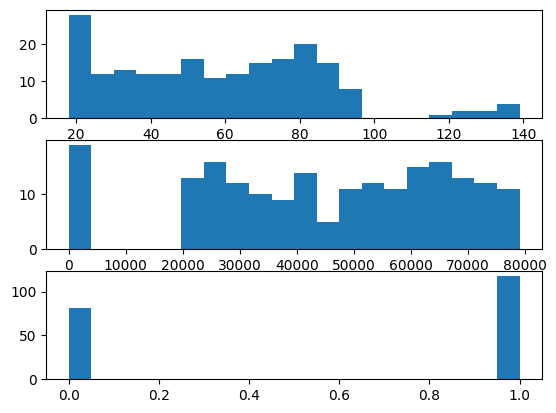

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore


fig,axes = plt.subplots(3)

# Calculate z-scores
z_scores = data.apply(zscore)

# Filter rows based on a z-score threshold
threshold =3
df_filtered = data[(z_scores < threshold).all(axis=1)]
for idx, column in enumerate(df_filtered.columns):
    axes[idx].hist(df_filtered[column],bins=20, label=column),
    #df_filtered.plot.hist(subplots=subplots,sharex=False)

#### **Exercise 2**

In the following, I've created a sample dataset with an exponential feature and a normal feature. Try using the different scaling methods before running the classifier.  How do your results change:

1.  If you scale the exponential feature using a StandardScaler
2.  If you scale the exponential feature using a Log transform

Logistic Regression without Scaling - Test Accuracy: 0.72


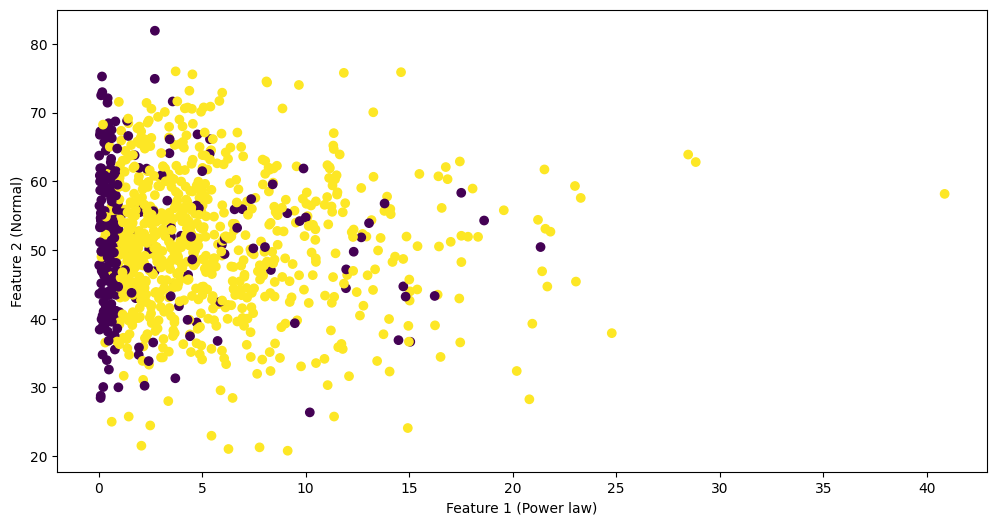

In [6]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic dataset
n_samples = 1000

# Feature 1: Power law (exponential) distribution
X1 = np.random.exponential(scale=5, size=n_samples)

# Feature 2: Normal distribution
X2 = np.random.normal(loc=50, scale=10, size=n_samples)

# Create labels: simple linear relation to X1 and X2
y = np.array([1 if x1 + 0.001 * x2 > 1 else 0 for x1, x2 in zip(X1, X2)])
flip_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
y[flip_indices] = 1 - y[flip_indices]



# Combine features into single data array
X = np.column_stack((X1, X2))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression without scaling
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(f"Logistic Regression without Scaling - Test Accuracy: {lr.score(X_test, y_test):.2f}")

# Plot original features
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1 (Power law)')
plt.ylabel('Feature 2 (Normal)')
plt.show()


(array([100., 128., 130., 152., 178., 133., 103.,  58.,  15.,   3.]),
 array([0.02294858, 0.39409211, 0.76523565, 1.13637919, 1.50752272,
        1.87866626, 2.24980979, 2.62095333, 2.99209687, 3.3632404 ,
        3.73438394]),
 <BarContainer object of 10 artists>)

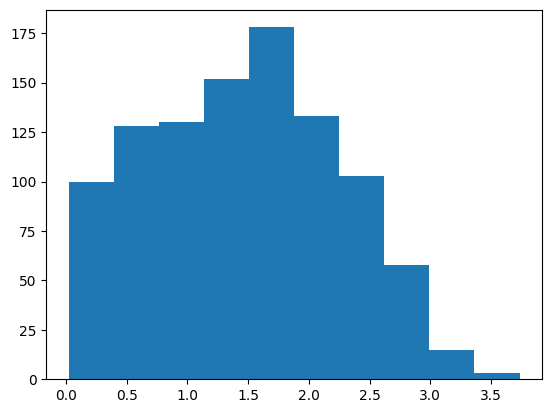

In [7]:
# Get a histogram of the power law feature after log-transforming
plt.hist(np.log(X[:,0]+1))

Logistic Regression with standard - Test Accuracy: 0.72


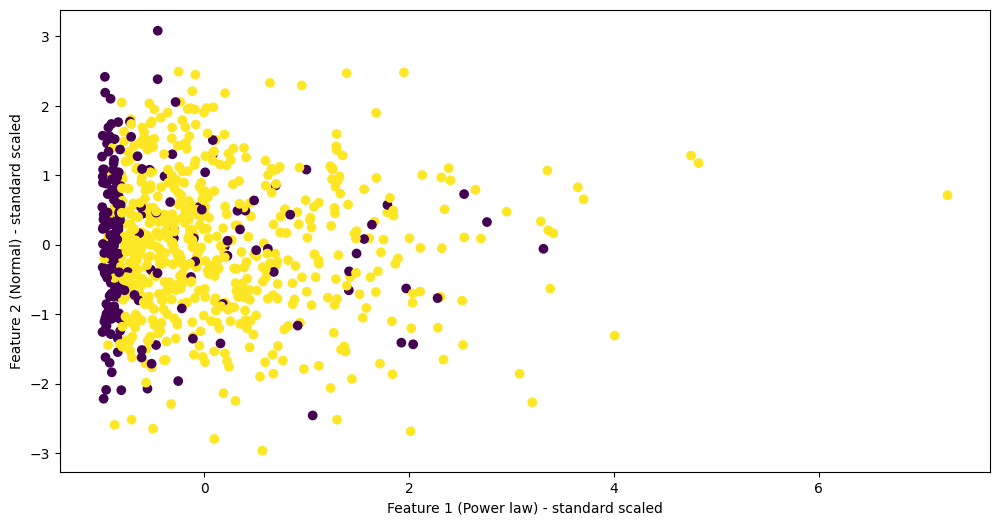

In [26]:
# Logistic Regression with StandardScaler, but no scaling - this is where class went wrong, there was an error in the viz where
# we were just seeing the same plot over again - Also some things hadn't been imported

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ("scalar",StandardScaler()),
    ("cls",LogisticRegression())
])


pipeline.fit(X_train, y_train)
X_train_standard_scaled = pipeline.named_steps['scalar'].transform(X_train)

y_pred = pipeline.predict(X_test)
print(f"Logistic Regression with standard - Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")


# Plot original features
plt.figure(figsize=(12, 6))
plt.scatter(X_train_standard_scaled[:, 0], X_train_standard_scaled[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Feature 1 (Power law) - standard scaled')
plt.ylabel('Feature 2 (Normal) - standard scaled')
plt.show()

Logistic Regression with standard - Test Accuracy: 0.91


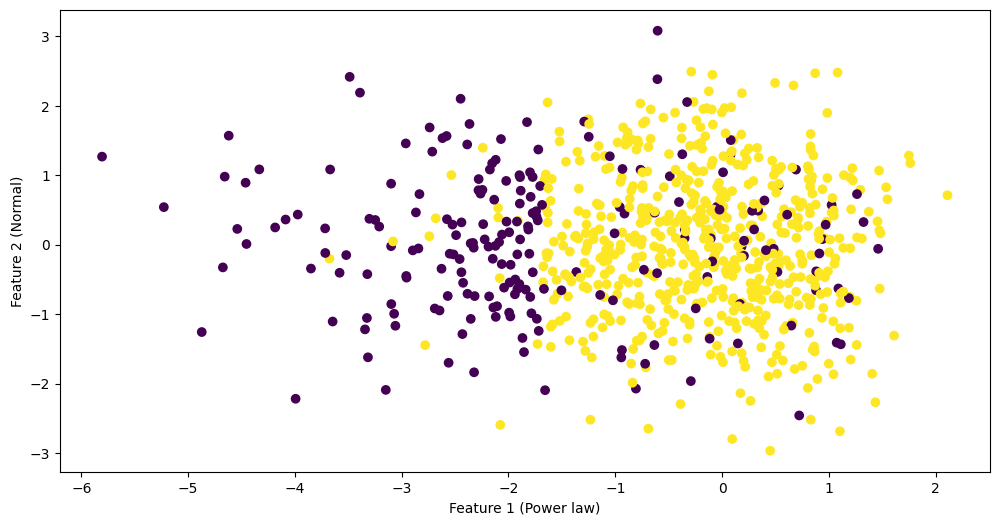

In [ ]:
# Try using regular StandardScaler on features after log-transforming the exponential feature
from sklearn.pipeline import Pipeline, FeatureUnion
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# Make a log-transform transformer
transformer = FunctionTransformer(np.log1p, validate=True)

ct = ColumnTransformer([
    ('log_transform', transformer,[0]) # the [0] is a hacky way of getting the right column in the transformer
],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('ct', ct),
    ('lr', LogisticRegression())
])

pipeline.fit(X_train, y_train)

# To look at the data as it is before logistic regression, run the pipeline up to the last step
X_train_standard_scaled_log = pipeline[:-1].fit_transform(X_train,y_train)


y_pred = pipeline.predict(X_test)
print(f"Logistic Regression with standard - Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Plot original features
plt.figure(figsize=(12, 6))
plt.scatter(X_train_standard_scaled_log[:, 0], X_train_standard_scaled_log[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Feature 1 (Power law) - standard scaled then log-transformed')
plt.ylabel('Feature 2 (Normal) - standard scaled')
plt.show()

#### **Exercise 3**

The **Titanic dataset** (link to the data from [last week](../2-week2//data/titanic.csv)) contains the passenger list for all 768 passengers on the Titanic, as well as who survived. In this exercise, try using different methods for dealing with the nulls in the "age" column, and running the same classifier for the different methods (you might try a DecisionTreeClassifier, or a LogisticRegression classifier, or a SGDClassifier).  Which one gives the best result?  Why do you think that is?  Please only use the following columns for modeling: pclass, sex, age, sibsp, parch.  Be sure to try the following methods:

1. Fill forward, using 'ffill' in Pandas
2. Use a "mean" with a SimpleImputer
3. Use a "most_frequent" with a simple imputer
4. Use a KNN imputer from sklearn

In [35]:
data = pd.read_csv("../2-week2/data/titanic.csv")
data_cleaned = data[['pclass','sex','age','sibsp','parch','survived']]
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   sex       1309 non-null   object 
 2   age       1046 non-null   float64
 3   sibsp     1309 non-null   int64  
 4   parch     1309 non-null   int64  
 5   survived  1309 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 61.5+ KB


In [75]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
# ffill

data_ffill = data_cleaned.ffill()

# For simplicity, wrap the testing in a function
def test(data,imputer):
    y = data['survived']
    X = data.drop("survived",axis=1)
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state= 42)
    tx = make_column_transformer((OneHotEncoder(),['sex']))
    pipeline = make_pipeline(tx,imputer,LogisticRegression(random_state= 12))
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    return accuracy_score(y_test,y_pred)

print('Test acc on SimpleImputer with mean: {}'.format(test(data_ffill,SimpleImputer(strategy="mean"))))
print('Test acc on SimpleImputer with most_frequent: {}'.format(test(data_ffill,SimpleImputer(strategy="most_frequent"))))
print('Test acc on KNNImputer with 5 neighbors: {}'.format(test(data_ffill,KNNImputer(n_neighbors=5))))


Test acc on SimpleImputer with mean: 0.7804878048780488
Test acc on SimpleImputer with most_frequent: 0.7804878048780488
Test acc on KNNImputer with 5 neighbors: 0.7804878048780488


#### **Exercise 4**

Use the one-hot encoding method introduced in [](4-encoding.ipynb) for encoding multiple columns to one-hot encode the following data. 

In [76]:
sample = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green'],
    'target': ['apple', 'sky', 'grass', 'sky', 'moon', 'apple'],
    'yumminess': [10,2,3,1,6,9]
})

# Your code here
# Assuming df is your DataFrame
# Initialize an empty DataFrame to hold the transformed columns
df_transformed = pd.DataFrame()

# Loop through each column in the original DataFrame
for col in sample.columns:
    # Check if the column is of object or category type
    if sample[col].dtype == 'object' or sample[col].dtype.name == 'category':
        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        
        # Fit and transform the column and convert it to a DataFrame
        one_hot_encoded = encoder.fit_transform(sample[[col]])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([col]))
        
        # Concatenate the one-hot-encoded DataFrame to the transformed DataFrame
        df_transformed = pd.concat([df_transformed, one_hot_df], axis=1)
    else:
        # If the column is not categorical, just copy it to the transformed DataFrame
        df_transformed[col] = sample[col].copy()

df_transformed


,color_green,color_red,target_grass,target_moon,target_sky,yumminess
0,0.0,1.0,0.0,0.0,0.0,10
1,0.0,0.0,0.0,0.0,1.0,2
2,1.0,0.0,1.0,0.0,0.0,3
3,0.0,1.0,0.0,0.0,1.0,1
4,0.0,0.0,0.0,1.0,0.0,6
5,1.0,0.0,0.0,0.0,0.0,9


#### **Exercise 5**

In along with this notebook, there is a data file called `synthetic_patient_unbalanced.csv` which simulates a dataset of patients who have been examined for cardiovascular disease (CVD).  The data contains the following columns:

#### Columns:
1. **gender** (Categorical): Gender of the patient. (Male, Female)
2. **age** (Numeric): Age of the patient.
3. **bmi** (Numeric): Body Mass Index of the patient.
4. **systolic_bp** (Numeric): Systolic blood pressure level of the patient.
5. **diastolic_bp** (Numeric): Diastolic blood pressure level of the patient.
6. **cholesterol_level** (Numeric): Cholesterol level of the patient. 
7. **exercise_frequency** (Categorical): How often the patient exercises.
8. **smoker** (Categorical): Whether the patient is a smoker or not. (0=No, 1=Yes).
9. **family_history** (Categorical): Whether the patient has a family history of the disease. (0=No, 1=Yes).
10. **diet_quality** (Categorical): Quality of the patient's diet. 
11. **us_state** (Categorical): The US State where the patient resides.
12. **has_disease** (Binary): Whether the patient has the disease or not. (0=No, 1=Yes).

#### Task:

1. After pre-processing the data, perform an end-to-end analysis.  
2. Evaluate precision, recall, f1-score, and accuracy using 5-fold cross-validation.

BONUS: See if you can figure out how to add SMOTE to the pipeline

In [78]:
data = pd.read_csv("./data/synthetic_patient_data_unbalanced.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1650 non-null   int64  
 1   gender              1650 non-null   object 
 2   age                 1650 non-null   int64  
 3   bmi                 1483 non-null   float64
 4   systolic_bp         1486 non-null   float64
 5   diastolic_bp        1489 non-null   float64
 6   exercise_frequency  1487 non-null   object 
 7   smoker              1485 non-null   float64
 8   family_history      1509 non-null   float64
 9   diet_quality        1480 non-null   object 
 10  us_state            1650 non-null   object 
 11  shoe_size           1650 non-null   float64
 12  cholesterol_level   1485 non-null   float64
 13  risk                1650 non-null   float64
 14  has_disease         1650 non-null   int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 193.5+

<Axes: ylabel='Frequency'>

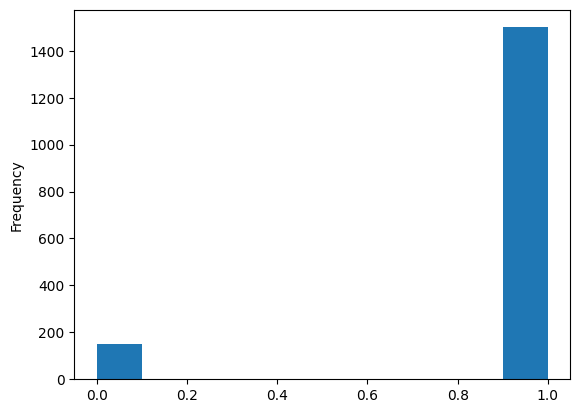

In [80]:
data['has_disease'].plot.hist()

In [81]:
data = data.drop("Unnamed: 0",axis=1)

# We don't have any nulls to worry about in the target, so we'll just pull out target / features at this point
data_features = data.drop("has_disease",axis=1)
data_target = data["has_disease"]

In [82]:
categorical = [col for col in data_features.columns if data_features[col].dtype == "object"]
for c in categorical:
    elts = [str(e) for e in data_features[c].unique()]
    print(f"Column {c}: {",".join(elts)}")

numeric = [col for col in data_features.columns if data_features[col].dtype in ["float64","int64"]]
print(f"Numeric: {numeric}")

Column gender: Female,Male
Column exercise_frequency: Never,Frequently,Regularly,Rarely,nan
Column diet_quality: Poor,Good,Average,nan
Column us_state: IL,PA,TX,CA,FL,GA,MI,NC,NY,OH
Numeric: ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'smoker', 'family_history', 'shoe_size', 'cholesterol_level', 'risk']


In [84]:
# Looking at this, it looks like exercise frequency and diet quality should be ordinal, and the others one hot (gender can be encoded with and ordinal encoder though).
data_features.head()

,gender,age,bmi,systolic_bp,diastolic_bp,exercise_frequency,smoker,family_history,diet_quality,us_state,shoe_size,cholesterol_level,risk
0,Female,78,28.645383,158.366502,131.550750,Never,1.0,NaN,Poor,IL,10.350641,374.351481,8.094770
1,Female,60,29.996090,109.359829,81.627726,Frequently,0.0,1.0,Poor,PA,8.964605,NaN,5.210414
2,Female,49,27.333974,166.396600,82.959320,Frequently,1.0,0.0,Poor,TX,12.497953,172.971294,4.121975
3,Female,36,NaN,147.342358,94.883134,Regularly,NaN,1.0,Good,CA,12.324542,183.111364,3.634515
4,Female,47,NaN,116.136687,102.252719,Rarely,0.0,1.0,Poor,TX,6.370078,334.957197,5.869982


In [85]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

binary_cols = ['smoker','family_history']
non_binary_cols = [x for x in numeric if x not in binary_cols]
oe_cols = ["gender","exercise_frequency","diet_quality"]
oe = OrdinalEncoder(categories=[["Female","Male"],["Never","Rarely","Regularly","Frequently"],["Poor","Average","Good"]])

oh_cols = ["us_state"]

# Using most frequent here, even though I'd prefer something smarter
oe_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),oe)

# just states
oh_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="first"))

# use most frequent here
binary_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Just median for all the rest, and scale
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

preprocessing = ColumnTransformer([
    ("OE",oe_pipeline,oe_cols),
    ("OH",oh_pipeline,oh_cols),
    ("BIN",binary_pipeline,binary_cols),
    ("NUM",num_pipeline,non_binary_cols)])

preprocessing.fit_transform(data)
preprocessing.get_feature_names_out()

array(['OE__gender', 'OE__exercise_frequency', 'OE__diet_quality',
       'OH__us_state_FL', 'OH__us_state_GA', 'OH__us_state_IL',
       'OH__us_state_MI', 'OH__us_state_NC', 'OH__us_state_NY',
       'OH__us_state_OH', 'OH__us_state_PA', 'OH__us_state_TX',
       'BIN__smoker', 'BIN__family_history', 'NUM__age', 'NUM__bmi',
       'NUM__systolic_bp', 'NUM__diastolic_bp', 'NUM__shoe_size',
       'NUM__cholesterol_level', 'NUM__risk'], dtype=object)

In [86]:
# Not rebalancing classes here
from sklearn.model_selection import cross_validate
pipeline = make_pipeline(preprocessing,LogisticRegression())

# We're using "macro" here so we can evaluate both of our classes - this is unusual for binary targets
cross_validate(pipeline,data_features,data_target,scoring=['f1_macro','precision_macro','recall_macro'])

{'fit_time': array([0.01824045, 0.01861215, 0.01712656, 0.01682401, 0.01678514]),
 'score_time': array([0.01573992, 0.01118994, 0.01398802, 0.0112052 , 0.01095104]),
 'test_f1_macro': array([0.99069348, 0.97119665, 0.9281962 , 0.99069348, 0.95041322]),
 'test_precision_macro': array([0.99833887, 0.9950495 , 0.98859935, 0.99833887, 0.99180328]),
 'test_recall_macro': array([0.98333333, 0.95      , 0.88333333, 0.98333333, 0.91666667])}

In [89]:
# Note that we need to use the pipeline from IMBLearn for this to work
#!pip install imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

pipeline = make_pipeline(preprocessing,SMOTE(), LogisticRegression())

# We're using "macro" here so we can evaluate both of our classes - this is unusual for binary targets
cross_validate(pipeline,data_features,data_target,scoring=['f1_macro','precision_macro','recall_macro'])

{'fit_time': array([0.04012227, 0.03775835, 0.04042792, 0.06573272, 0.03116512]),
 'score_time': array([0.03077507, 0.01828456, 0.03593683, 0.02039814, 0.01903915]),
 'test_f1_macro': array([1.        , 0.98109749, 0.945     , 0.98166667, 0.98109749]),
 'test_precision_macro': array([1.        , 0.99668874, 0.945     , 0.98166667, 0.99668874]),
 'test_recall_macro': array([1.        , 0.96666667, 0.945     , 0.98166667, 0.96666667])}